In [1]:
import sys
import glob
import os
import glob
import numpy as np
import cv2
from PIL import Image
import pytesseract
import re
import matplotlib.pyplot as plt

In [110]:
def plot_img(img, title):
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [111]:
def ratioCheck(area, width, height):
        ratio = float(width) / float(height)
        if ratio < 1:
            ratio = 1 / ratio
        if (area < 1063.62 or area > 73862.5) or (ratio < 3 or ratio > 6):
            return False
        return True

In [167]:
def clean2_plate(plate):
        gray_img = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray_img, 110, 255, cv2.THRESH_BINARY)
        if cv2.waitKey(0) & 0xff == ord('q'):
            pass
        num_contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if num_contours:
            contour_area = [cv2.contourArea(c) for c in num_contours]
            max_cntr_index = np.argmax(contour_area)
            max_cnt = num_contours[max_cntr_index]
            max_cntArea = contour_area[max_cntr_index]
            x, y, w, h = cv2.boundingRect(max_cnt)

            if not ratioCheck(max_cntArea, w, h):
                return plate, None

            final_img = thresh[y:y+h, x:x+w]   
            return final_img, [x, y, w, h]

        else:
            return plate, None
        

In [112]:
def isMaxWhite(plate):
        avg = np.median(plate)
        if avg >= 115:
            return True
        else:
            return False

def ratio_and_rotation(rect):
    (x, y), (width, height), rect_angle = rect
    if width > height:
        angle = -rect_angle
    else:
        angle = 90 + rect_angle
    if angle > 180:
        return False
    if height == 0 or width == 0:
        return False
    area = height * width
    if not ratioCheck(area, width, height):
        return False
    else:
        return True

In [165]:
# Detecting numberplate
def number_plate_detection(img):
    img_with_contours=img.copy()
    plot_img(img, "Original Image")
    img2 = cv2.GaussianBlur(img, (5, 5), 0)
    plot_img(img2, "Gaussian Blur")
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    plot_img(img2, "GrayScale Image")
    img2 = cv2.Sobel(img2, cv2.CV_8U, 1, 0, ksize=3)
    plot_img(img2, "Sobel Edge Detection")
    _, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    plot_img(img2, "Thresholding")
    element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
    morph_img_threshold = img2.copy()
    cv2.morphologyEx(src=img2, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
    num_contours, _ = cv2.findContours(morph_img_threshold, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    plot_img(morph_img_threshold, "Morphed Image")

    for cnt in num_contours:
        min_rect = cv2.minAreaRect(cnt)
        if ratio_and_rotation(min_rect):
            x, y, w, h = cv2.boundingRect(cnt)
            plate_img = img[y:y+h, x:x+w]
            if isMaxWhite(plate_img):
                clean_plate, rect = clean2_plate(plate_img)
                plot_img(clean_plate,"clean_plate")
                if rect:
                    x1, y1, w1, h1 = rect
                    x, y, w, h = x+x1, y+y1, w1, h1
                    cv2.rectangle(img_with_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding rectangle
                    plate_im = Image.fromarray(clean_plate)
                    text = pytesseract.image_to_string(plate_im, lang='eng')
                    return text, clean_plate, img_with_contours,plate_img 
    return None, None, img_with_contours, None

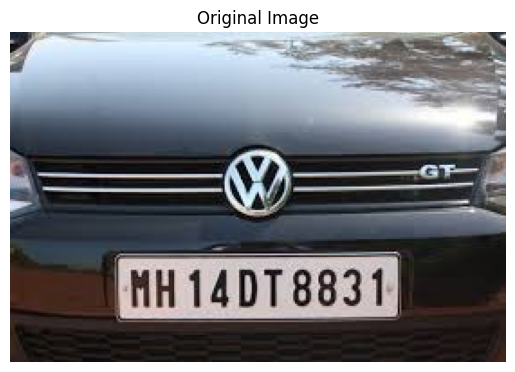

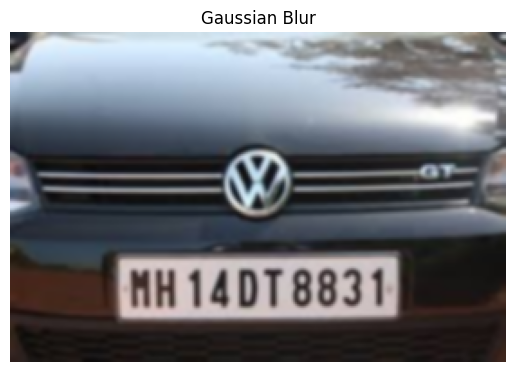

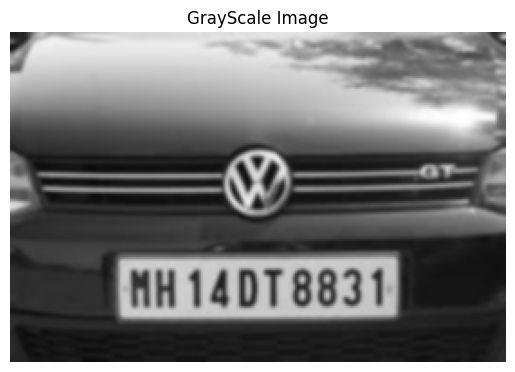

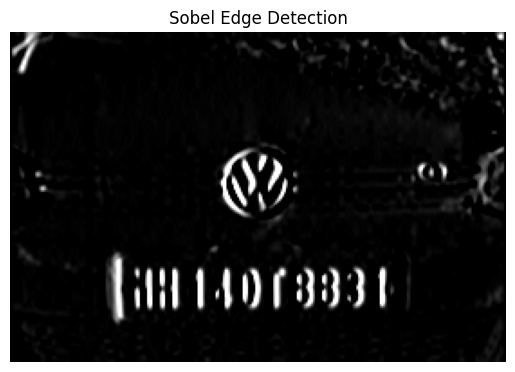

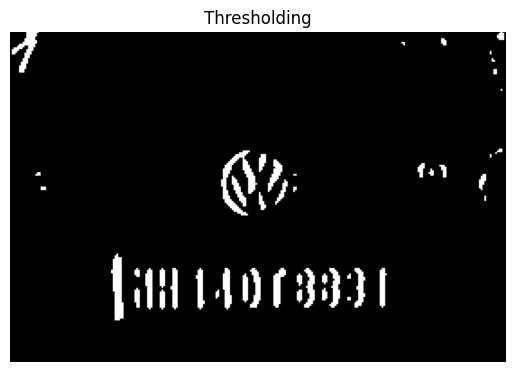

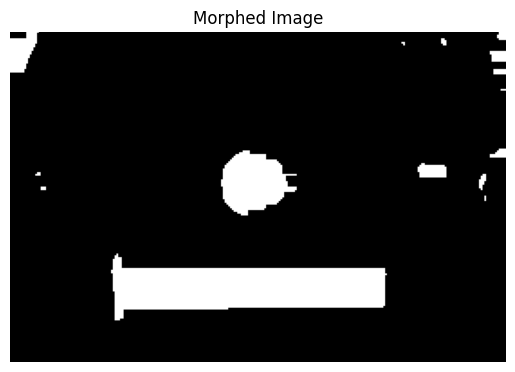

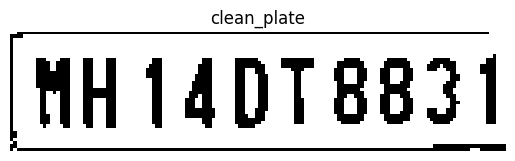

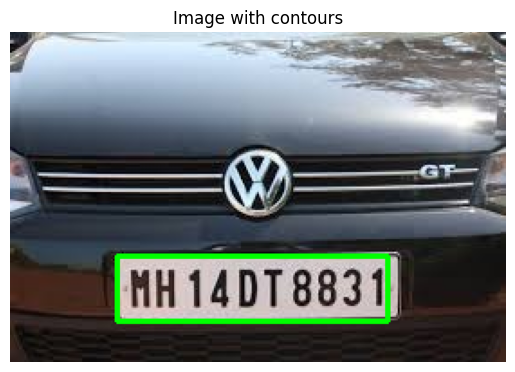

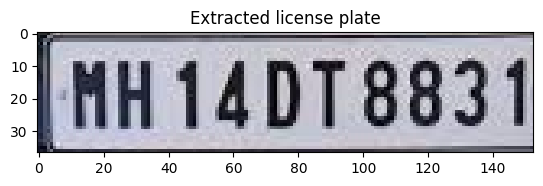

Detected License Plate Number is: HH14078831


In [185]:
img_path = "./Dataset/3.jpeg"
img = cv2.imread(img_path)
text, clean_plate, img_with_contours, ROI = number_plate_detection(img)
plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Image with contours")
plt.axis('off')
plt.show()
plt.imshow(ROI)
plt.title("Extracted license plate")
plt.show()

try:
    res2 = str("".join(re.split("[^a-zA-Z0-9]*", text)))
    res2 = res2.upper()
    if res2 == "":
        print("No Plate Found")
    else:
        print("Detected License Plate Number is:",res2)
except Exception as e:
    print("No Plate found")

In [148]:
import imutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from sklearn.metrics import f1_score
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [144]:
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list, img_binary_lp

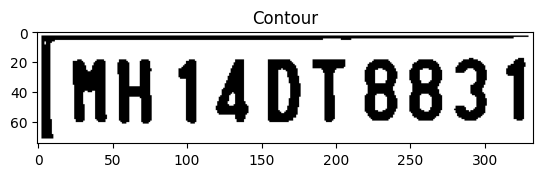

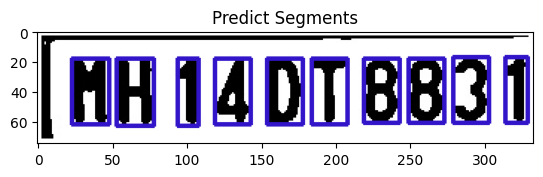

In [186]:
char, image_binary=segment_characters(ROI)

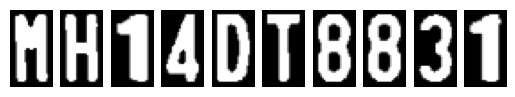

In [187]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

In [5]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = './data/data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [7]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [8]:
batch_size = 1
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 25, verbose=1, callbacks=None)

Epoch 1/25
  1/864 ━━━━━━━━━━━━━━━━━━━━ 29:44 2s/step - accuracy: 0.0000e+00 - loss: 3.5946

c:\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


864/864 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - accuracy: 0.0333 - loss: 3.5729 - val_accuracy: 0.1759 - val_loss: 2.8278
Epoch 2/25


c:\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1806 - val_loss: 2.8016
Epoch 3/25
864/864 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.3136 - loss: 2.4271 - val_accuracy: 0.6296 - val_loss: 1.2336
Epoch 4/25
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6574 - val_loss: 1.2144
Epoch 5/25
864/864 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.7241 - loss: 0.9302 - val_accuracy: 0.8287 - val_loss: 0.5011
Epoch 6/25
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8287 - val_loss: 0.4867
Epoch 7/25
864/864 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.8510 - loss: 0.4499 - val_accuracy: 0.9352 - val_loss: 0.2332
Epoch 8/25
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9352 - val_loss: 0.2254
Epoch 9/25
864/864 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9258 

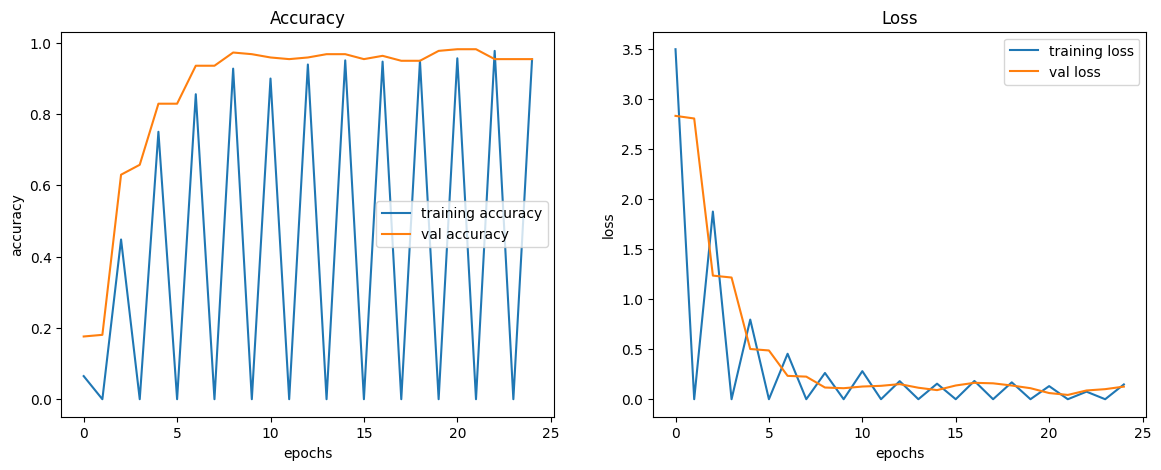

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [16]:
import os

# Create the directory if it doesn't exist
checkpoint_dir = './checkpoints/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Now save the weights
model.save_weights(os.path.join(checkpoint_dir, 'my_checkpoint.weights.h5'))

In [20]:
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('./checkpoints/my_checkpoint.weights.h5')

In [188]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_prob = loaded_model.predict(img)[0] #predicting the probabilities
        y_class = np.argmax(y_prob) #finding the class with the highest probability
        character = dic[y_class]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print("Detected License Plate Number is:",show_results())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Detected License Plate Number is: HH14DT8831


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

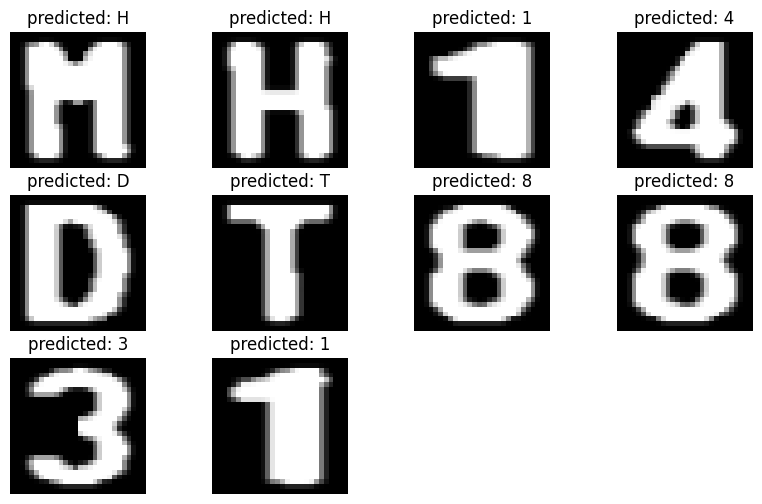

In [189]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()